In [ ]:
#!pip install tensorflow==2.0.0b1

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [3]:
# updated for binary classification
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # No need to expand dims in multivariate
    # series_dim is greater than one so python will not create rank-1 array
    # Before we had to change the (2500,) array to (2500,1) array
    # Since we start with more than one feature, we'll already have (2500,2)
    #series = tf.expand_dims(series, axis = -1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # updated to send only the binary classification column "Warm" to the label
    dataset = dataset.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[-1:, -1:]))
    return dataset.batch(batch_size).prefetch(1)


In [4]:
tf.keras.backend.clear_session()
# modified daily-min-temperatures.csv by adding a binary variable "Warm"
# Warm if degrees in Farenheit is greater than 55
columns = ['Temp', 'Warm']
df = pd.read_csv('tmp/daily-min-temperatures_binary.csv')
# set up number of series dimensions for multivariate classification
# 2 columns in X: previous day's Temp and Warm
# 1 column in Y: next day's Warm classification
series_dim = len(columns)
print('multivariate problem with series_dim of {}'.format(series_dim))
print(df[columns].head().to_numpy().astype(float))

multivariate problem with series_dim of 2
[[20.7  1. ]
 [17.9  1. ]
 [18.8  1. ]
 [14.6  1. ]
 [15.8  1. ]]


In [5]:
# no change to hyperparameters
window_size = 25
batch_size = 50
shuffle_buffer_size = 100
split_time = 2500

# split into train and validation sets
series = df[columns].to_numpy().astype(float)
time = df['Date'].to_numpy()
x_train = series[:split_time]
time_train = time[:split_time]
x_valid = series[split_time:]
time_valid = time[split_time:]

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# check shape of x's and y's (batch_size, window_size, series_dim)
# x's: (50, 25, 2)
# y's: (50, 1, 1)
x, y = next(iter(train_set))
print(x.shape)
print(y.shape)


(50, 25, 2)
(50, 1, 1)


In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 100, kernel_size = 5, strides = 1, padding = 'causal', 
                           activation = 'relu', input_shape = [window_size, series_dim]),
    #tf.keras.layers.MaxPooling1D(2, 2),
    #tf.keras.layers.Dropout(0.1),
    # input_shape needs to know series_dim
    tf.keras.layers.LSTM(100, return_sequences = True),
    tf.keras.layers.LSTM(50, return_sequences = True),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(50, activation = 'relu'),
    tf.keras.layers.Dense(25, activation = 'relu'),
    # use sigmoid for binary classification
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 25, 100)           1100      
_________________________________________________________________
lstm (LSTM)                  (None, 25, 100)           80400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 50)            30200     
_________________________________________________________________
dense (Dense)                (None, 25, 50)            2550      
_________________________________________________________________
dense_1 (Dense)              (None, 25, 25)            1275      
_________________________________________________________________
dense_2 (Dense)              (None, 25, 1)             26        
Total params: 115,551
Trainable params: 115,551
Non-trainable params: 0
__________________________________________________

In [7]:
# updated loss parameter to binary classification
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr = 1e-5),
              metrics=["acc"])

history = model.fit(train_set, epochs=200)

Epoch 1/200
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
50/50 [==============================] - 4s 75ms/step - loss: 0.6802 - acc: 0.6656
Epoch 2/200
50/50 [==============================] - 2s 35ms/step - loss: 0.6568 - acc: 0.6834
Epoch 3/200
50/50 [==============================] - 2s 35ms/step - loss: 0.6448 - acc: 0.6832
Epoch 4/200
50/50 [==============================] - 2s 34ms/step - loss: 0.6360 - acc: 0.6832
Epoch 5/200
50/50 [==============================] - 2s 34ms/step - loss: 0.6280 - acc: 0.6832
Epoch 6/200
50/50 [==============================] - 2s 35ms/step - loss: 0.6205 - acc: 0.6840
Epoch 7/200
50/50 [==============================] - 2s 35ms/step - loss: 0.6133 - acc: 0.6857
Epoch 8/200
50/50 [==============================] - 2s 34ms/step - loss: 0.6064 - acc: 0.6892
Epoch 9/200
50/50 [==============================] - 2s 34ms/step - loss: 0.5995 - acc: 0.6969
Epoch 10/200
50/50 [==============================]

50/50 [==============================] - 2s 35ms/step - loss: 0.4789 - acc: 0.7690
Epoch 83/200
50/50 [==============================] - 2s 34ms/step - loss: 0.4786 - acc: 0.7692
Epoch 84/200
50/50 [==============================] - 2s 34ms/step - loss: 0.4783 - acc: 0.7692
Epoch 85/200
50/50 [==============================] - 2s 35ms/step - loss: 0.4781 - acc: 0.7693
Epoch 86/200
50/50 [==============================] - 2s 34ms/step - loss: 0.4778 - acc: 0.7694
Epoch 87/200
50/50 [==============================] - 2s 34ms/step - loss: 0.4776 - acc: 0.7697
Epoch 88/200
50/50 [==============================] - 2s 34ms/step - loss: 0.4773 - acc: 0.7696
Epoch 89/200
50/50 [==============================] - 2s 34ms/step - loss: 0.4771 - acc: 0.7699
Epoch 90/200
50/50 [==============================] - 2s 34ms/step - loss: 0.4768 - acc: 0.7700
Epoch 91/200
50/50 [==============================] - 2s 35ms/step - loss: 0.4766 - acc: 0.7700
Epoch 92/200
50/50 [==============================] -

50/50 [==============================] - 2s 35ms/step - loss: 0.4669 - acc: 0.7753
Epoch 167/200
50/50 [==============================] - 2s 34ms/step - loss: 0.4668 - acc: 0.7754
Epoch 168/200
50/50 [==============================] - 2s 34ms/step - loss: 0.4667 - acc: 0.7754
Epoch 169/200
50/50 [==============================] - 2s 34ms/step - loss: 0.4667 - acc: 0.7755
Epoch 170/200
50/50 [==============================] - 2s 35ms/step - loss: 0.4666 - acc: 0.7755
Epoch 171/200
50/50 [==============================] - 2s 34ms/step - loss: 0.4665 - acc: 0.7755
Epoch 172/200
50/50 [==============================] - 2s 34ms/step - loss: 0.4664 - acc: 0.7754
Epoch 173/200
50/50 [==============================] - 2s 34ms/step - loss: 0.4663 - acc: 0.7755
Epoch 174/200
50/50 [==============================] - 2s 34ms/step - loss: 0.4663 - acc: 0.7755
Epoch 175/200
50/50 [==============================] - 2s 34ms/step - loss: 0.4662 - acc: 0.7756
Epoch 176/200
50/50 [=======================

In [9]:
# forecast
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset = dataset.window(window_size, shift = 1, drop_remainder = True)
dataset = dataset.flat_map(lambda window: window.batch(window_size))
dataset = dataset.batch(batch_size).prefetch(1)
forecast = model.predict(dataset)
rnn_forecast = forecast[split_time - window_size:-1, -1, 0]

In [10]:
# check validation scores
rnn_class = (rnn_forecast > 0.5)
print('Classification accuracy {:.4f}'.format(accuracy_score(x_valid[:, -1].astype(bool), rnn_class)))
print('ROC AUC {:.4f}'.format(roc_auc_score(x_valid[:, -1], rnn_forecast)))

Classification accuracy 0.8026
ROC AUC 0.8878


<Figure size 432x288 with 0 Axes>

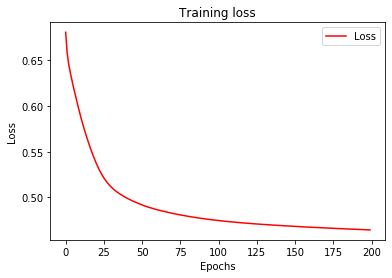

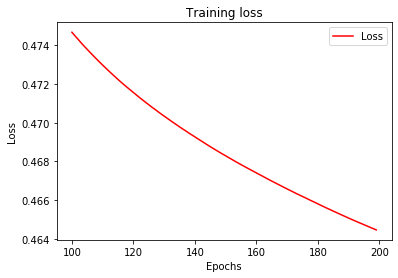

<Figure size 432x288 with 0 Axes>

In [15]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()


start_epoch = len(loss) - 100
zoomed_loss = loss[start_epoch:]
zoomed_epochs = range(start_epoch,len(loss))


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()